# Multiple regression analysis with 2 independent variables using SQL
#### Home prices `y` based on the number of bedrooms `x1` and the number of bathrooms `x2`.(Obviously not in the Bay Area!)
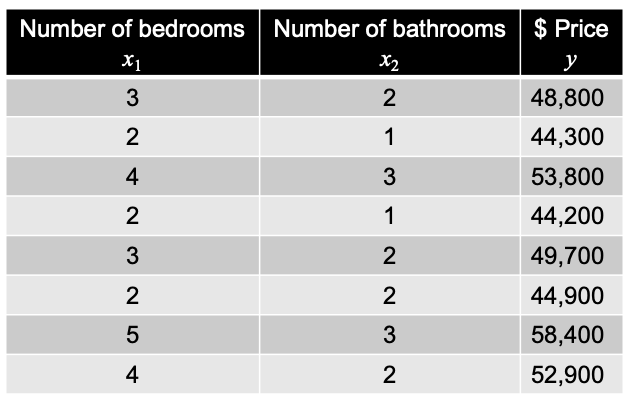. 


#### Use regression analysis to estimate the price of another home with 2 bedrooms and 1 bathroom, and the price of another home with 5 bedrooms and 3 bathrooms.
#### This is a multiple regression problem because we have more than one independent variables `x1` and `x2`. The regression equation is
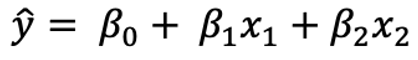
#### Just as we had to calculate linear regression coefficients `m` and `b`, we need to calculate the multiple regression coefficients `β0`, `β1`, and `β2`.

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from data201 import db_connection, df_query

In [ ]:
bedrooms  = [         3,          2,          4,          2,          3,          2,          5,          4]
bathrooms = [         2,          1,          3,          1,          2,          2,          3,          2]
prices    = [488_000.00, 443_000.00, 538_000.00, 442_000.00, 497_000.00, 449_000.00, 584_000.00, 529_000.00]

df = DataFrame({'bedrooms': bedrooms, 'bathrooms': bathrooms, 'prices': prices})

pd.options.display.float_format = '${:,.2f}'.format
df

In [ ]:
conn = db_connection(config_file = 'homes.ini')
cursor = conn.cursor()

In [ ]:
cursor.execute('DROP TABLE IF EXISTS homes')

cursor.execute(
    """
    CREATE TABLE homes
    (
        id        INT NOT NULL,
        bedrooms  INT NOT NULL,
        bathrooms INT NOT NULL,
        price     DOUBLE,
        PRIMARY KEY(id)
    )
    """
)

In [ ]:
values = list(zip(range(len(prices)), bedrooms, bathrooms, prices))
values

## Load the `homes` table

In [ ]:
sql = ( """
        INSERT INTO homes
        VALUES (%s, %s, %s, %s)
        """
      )

cursor.executemany(sql, values)
conn.commit()

In [ ]:
pd.options.display.float_format = '${:,.2f}'.format

df_query(conn, 'SELECT * FROM homes')

## Calculate correlation coefficients with SQL
#### Perform matrix arithmetic.

In [ ]:
ctes = (
    """
    WITH
        base AS (
    		SELECT
    			id,
    
    			bedrooms                          AS x1,
    			bedrooms - AVG(bedrooms) OVER()   AS x1_centered,
    
    			bathrooms                         AS x2,
    			bathrooms - AVG(bathrooms) OVER() AS x2_centered,
    
    			price                             AS y,
    			price - AVG(price) OVER()         AS y_centered
    		FROM homes
    	),
     
    	univariate_regression AS (
    		SELECT
    			AVG(x2) - AVG(x1) * SUM(x2_centered * x1_centered)
    					  / SUM(x1_centered * x1_centered)         AS x1_const,
    			SUM(x2_centered * x1_centered)
    					  / SUM(x1_centered * x1_centered)         AS beta1,
    			AVG(x1) - AVG(x2) * SUM(x1_centered * x2_centered)
    					  / SUM(x2_centered * x2_centered)         AS x2_const,
    			SUM(x1_centered * x2_centered)
    					  / SUM(x2_centered * x2_centered)         AS beta2
    		FROM base
    	),
     
        residuals AS (
    		SELECT
    			x1,
    			x1 - (SELECT beta2    FROM univariate_regression) * x2
    			   - (SELECT x2_const FROM univariate_regression)      AS x1_resid,
    
    			x2,
    			x2 - (SELECT beta1    FROM univariate_regression) * x1
    			   - (SELECT x1_const FROM univariate_regression)      AS x2_resid,
    
    			y,
    			y_centered
    		FROM base
    	),
     
        multiple_regression_2 AS (
    		SELECT
    			AVG(y) - AVG(x1) * SUM(y_centered * x1_resid)
    					 / SUM(x1_resid * x1_resid)
    				   - AVG(x2) * SUM(y_centered * x2_resid)
    					 / SUM(x2_resid * x2_resid)           AS beta0,
    			SUM(y_centered * x1_resid)
    				/ SUM(x1_resid * x1_resid)                AS beta1,
    			SUM(y_centered * x2_resid)
    				/ SUM(x2_resid * x2_resid)                AS beta2
    		FROM residuals
    	)
    
    SELECT * FROM multiple_regression_2
    """
)

In [ ]:
df = df_query(conn, ctes)
df

## Estimates

In [ ]:
β0 = df.iloc(0)[0].beta0
β1 = df.iloc(0)[0].beta1
β2 = df.iloc(0)[0].beta2

In [ ]:
est_2_1 = β0 + 2*β1 + 1*β2
est_5_3 = β0 + 5*β1 + 3*β2

print(f'est_2_1 = ${est_2_1:,.2f}')
print(f'est_5_3 = ${est_5_3:,.2f}')

In [ ]:
cursor.close()
conn.close()